---
## Assignment 1.4: Spatial Power Law

Is crime spread evenly across San Francisco, or is it concentrated in a small number of hotspots? Let's find out.

*Draws from*: Week 4, Exercise 2.2.

Use your **most common Personal Focus Crime** (by total incident count) for this exercise.

> * **Step 1**: Divide San Francisco into a grid of approximately $100\text{m} \times 100\text{m}$ cells using latitude and longitude. It is fine to ignore that the Earth isn't flat — the approximation is good enough for this purpose.
>     * **Hint**: `np.histogram2d` works well here. Focus on points within the SF peninsula; filter out geographic outliers.
> * **Step 2**: Count the number of incidents of your chosen crime in each grid cell (use all years of data).
> * **Step 3**: Tally the distribution. Count how many cells have exactly $k$ incidents — call this $N(k)$ — for $k = 0, 1, 2, \ldots$ up to the maximum.
> * **Step 4**: Plot $(k+1)$ vs $N(k)$ on **linear axes**.
> * **Step 5**: Plot $(k+1)$ vs $N(k)$ on **loglog axes**.
> * **Step 6**: Does your crime follow a power-law spatial distribution? How can you tell from the loglog plot?
> * **Step 7**: If crime is spatially concentrated in a small number of cells, what does that imply for how we interpret neighborhood-level crime statistics? Does the "average block" tell you anything useful?

In [12]:
import pandas as pd
df = pd.read_csv('merged_sfpd.csv')
df['incident_category'] = df['incident_category'].replace('Larceny Theft', 'LARCENY/THEFT')

In [19]:

personal_focus = [
    'LARCENY/THEFT',
    'NON-CRIMINAL',
    'ASSAULT',
    'VEHICLE THEFT',
    'DRUG/NARCOTIC',
    'VANDALISM',
    'WARRANTS',
    'BURGLARY',
    'SUSPICIOUS OCC'
]

df_pf = df[df['incident_category'].isin(personal_focus)].copy()
df_pf['incident_category'].value_counts()


incident_category
LARCENY/THEFT     772367
NON-CRIMINAL      179139
ASSAULT           167042
VEHICLE THEFT     126228
DRUG/NARCOTIC     117821
VANDALISM         114718
WARRANTS           99821
BURGLARY           91067
SUSPICIOUS OCC     79087
Name: count, dtype: int64

The chosen crime category for this assignment is **Larceny/Theft** as this is the most common personal focus crime in the dataset. 

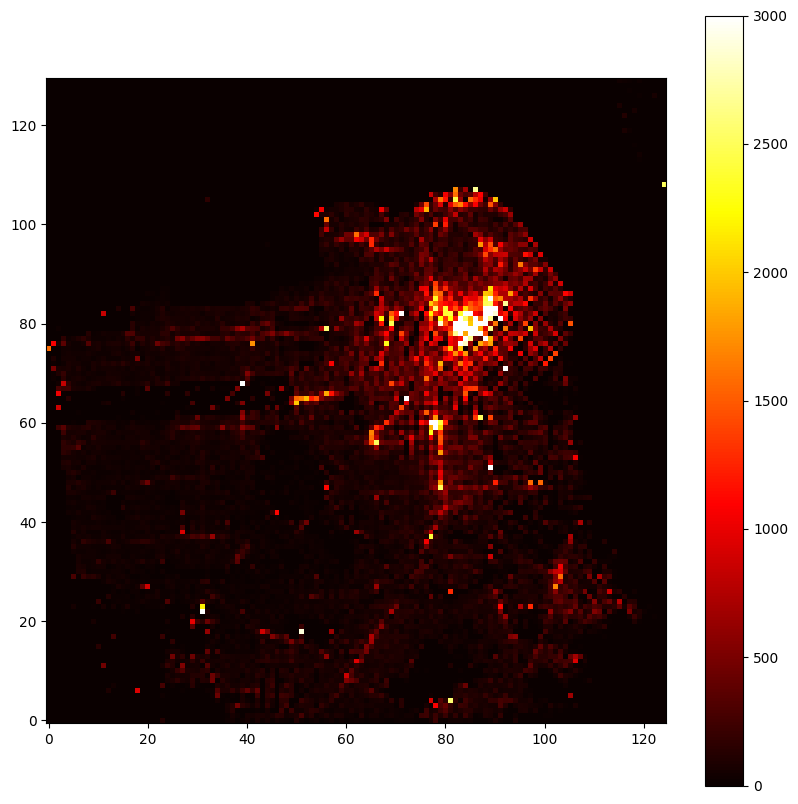

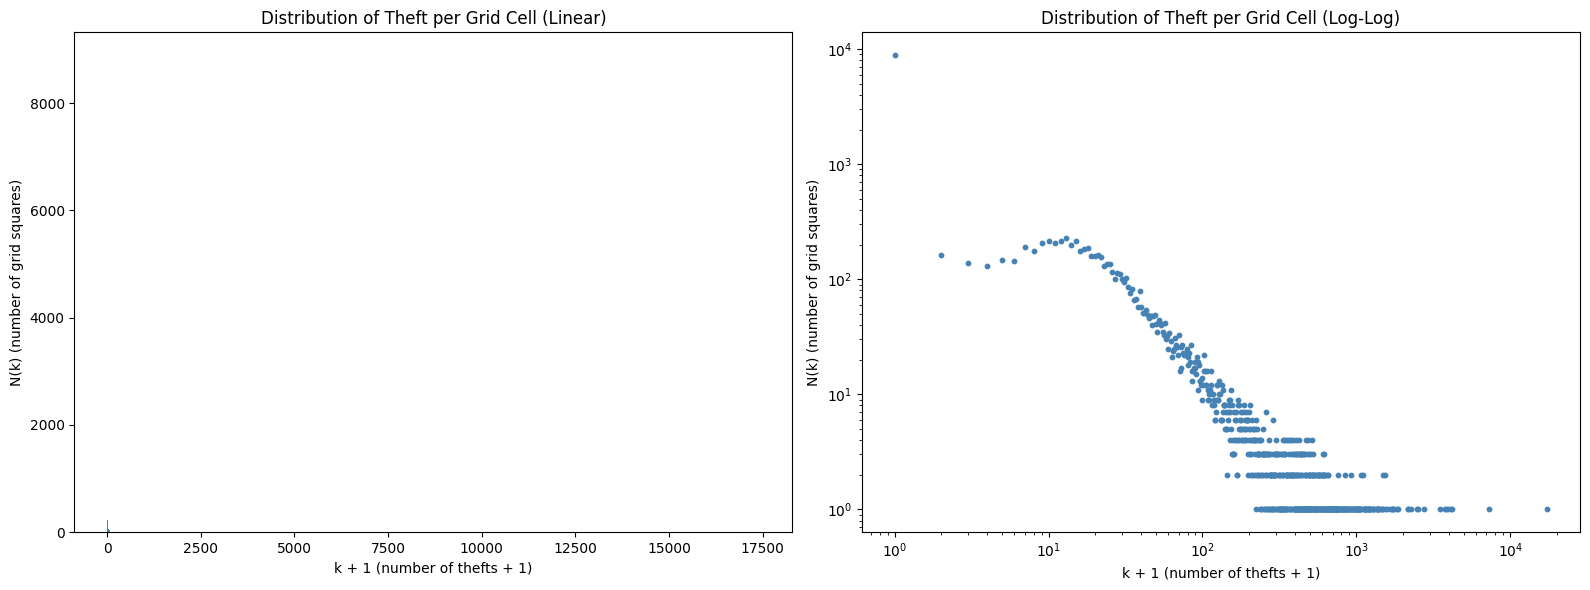

Grid size: 135 x 130 = 17550 cells
Max thefts in a single cell: 17418
Cells with zero thefts: 8876


In [18]:
import pandas as pd
from math import radians, cos, sin, asin, sqrt
import numpy as np
import matplotlib.pyplot as plt

df_pf = df_pf[(df_pf['latitude'] < 50) & (df_pf['longitude'] < -122)]
    


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r



lat_min = df_pf['latitude'].min()
lat_max = df_pf['latitude'].max()
lon_min = df_pf['longitude'].min()
lon_max = df_pf['longitude'].max()

count, lon, lat = np.histogram2d(df_pf['latitude'], df_pf['longitude'], bins = [130,125])



plt.figure(figsize=(10,10))
plt.imshow(count, cmap='hot',vmax=3000, origin='lower')
plt.colorbar()

# Step 1 & 2: Bin thefts into ~100m x 100m grid and count
# Calculate approximate bin sizes
lat_range = lat_max - lat_min
lon_range = lon_max - lon_min

# ~100m in latitude is about 0.0009 degrees, ~100m in longitude at SF latitude is about 0.0011 degrees
lat_bins = int(haversine(lon_min, lat_min, lon_min, lat_max) * 1000 / 100)
lon_bins = int(haversine(lon_min, lat_min, lon_max, lat_min) * 1000 / 100)

# Filter theft data to SF peninsula (remove outliers)
theft = df_pf[df_pf['incident_category'] == 'LARCENY/THEFT'].copy()
mask = (theft['latitude'] > lat_min) & (theft['latitude'] < lat_max) & \
    (theft['longitude'] > lon_min) & (theft['longitude'] < lon_max)
theft = theft[mask]

counts, lat_edges, lon_edges = np.histogram2d(
    theft['latitude'].values, theft['longitude'].values, bins=[lat_bins, lon_bins]
)

# Step 3: Tally the counts
grid_counts = counts.flatten().astype(int)
k_max = grid_counts.max()
k_values = np.arange(0, k_max + 1)
N_k = np.array([np.sum(grid_counts == k) for k in k_values])

# Step 4 & 5: Plot on linear and loglog axes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear axes
axes[0].bar(k_values + 1, N_k, width=1, color='steelblue', edgecolor='none')
axes[0].set_xlabel('k + 1 (number of thefts + 1)')
axes[0].set_ylabel('N(k) (number of grid squares)')
axes[0].set_title('Distribution of Theft per Grid Cell (Linear)')

# Log-log axes
nonzero = N_k > 0
axes[1].scatter(k_values[nonzero] + 1, N_k[nonzero], s=10, color='steelblue')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('k + 1 (number of thefts + 1)')
axes[1].set_ylabel('N(k) (number of grid squares)')
axes[1].set_title('Distribution of Theft per Grid Cell (Log-Log)')

plt.tight_layout()
plt.show()

print(f"Grid size: {lat_bins} x {lon_bins} = {lat_bins * lon_bins} cells")
print(f"Max thefts in a single cell: {k_max}")
print(f"Cells with zero thefts: {N_k[0]}")